In [1777]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.transform as R
from numpy.linalg import inv, pinv, norm

In [1778]:
# our target point in 3D
# this is the point we want to triangulate
t_target = np.array([1.5, 0.5, 0.3])
# number of cameras
n_cam = 2
# translation of the cameras
t_cam = np.zeros((3,n_cam))
t_cam[:,0] = np.array([0,0,0])
t_cam[:,1] = np.array([0,1,0])
# rotation of the cameras
R_cam = np.zeros((3,3,n_cam))
R_cam[:,:,0] = R.Rotation.from_euler('xyz', [0.0, np.pi / 2, 0.0]).as_matrix()
R_cam[:,:,1] = R.Rotation.from_euler('xyz', [0.0, np.pi / 2, 0.0]).as_matrix()
# intrinsic camera parameters (focal length and principal point) assume same for all cameras
F_cam = np.zeros((3,3,n_cam))
F_cam[:,:,0] = np.array([[300, 0, 1080/2],[0, 300, 720/2],[0, 0, 1]])
F_cam[:,:,1] = F_cam[:,:,0].copy()

In [1779]:
def genPixelCoordinates(n_cam, F_cam, R_cam, t_cam, t_target, noise=0.0):
    """
    Generate pixel coordinates for the target point in each camera frame.
    """
    p_target = np.zeros((3,n_cam))
    z_target = np.zeros(n_cam)
    for i in range(n_cam):
        # project target point into camera frame, using pinhole camera model
        # no noise is assumed in this example
        p_target[:,i] = F_cam[:,:,i] @ R_cam[:,:,i].T @ (t_target - t_cam[:,i])
    z_target = p_target[2,:].copy()
    p_target /= z_target
    # add noise to pixel coordinates
    p_target += noise * (np.random.random((3,n_cam)) - 0.5) * 2.0
    p_target[2,:] = 1
    return p_target, z_target

In [1780]:
def buildLinearSystem(n_cam, F_cam, R_cam, t_cam, p_target):
    """
    Build the linear system of equations for triangulation.
    """
    A_cam = np.zeros((3, n_cam))
    for i in range(n_cam):
        A_cam[:,i] = R_cam[:,:,i] @ inv(F_cam[:,:,i]) @ p_target[:,i]
    b_cam = t_cam.copy()
    return A_cam, b_cam

In [1781]:
def solveLinearSystem(n_cam, A_cam, b_cam):
    """
    Solve the linear system of equations for triangulation.
    """
    A = np.zeros((3*n_cam, n_cam))
    b = np.zeros(3*n_cam)
    for i in range(n_cam):
        A[(3*i):(3*i+3), i] = A_cam[:,i]
        b[(3*i):(3*i+3)] = b_cam[:,i]
    A = np.hstack((A, np.tile(-np.eye(3), (n_cam, 1))))

    result = -pinv(A) @ b
    z_sol = result[0:n_cam]
    t_sol = result[n_cam:n_cam+3]
    return z_sol, t_sol

In [1782]:
p_target, z_target = genPixelCoordinates(n_cam, F_cam, R_cam, t_cam, t_target)
A_cam, b_cam = buildLinearSystem(n_cam, F_cam, R_cam, t_cam, p_target)
z_sol, t_sol = solveLinearSystem(n_cam, A_cam, b_cam)

print(f'Error for target: {t_sol - t_target}')
print(f'Error for depth: {z_sol - z_target}')

Error for target: [-6.66133815e-16 -5.55111512e-17 -3.33066907e-16]
Error for depth: [-1.33226763e-15 -1.33226763e-15]


In [1783]:
def plotSolution(t_target, t_cam, R_cam, z_sol, filename=None):
    """
    Plot the triangulated solution and the camera models.
    """
    cam_length = 0.3
    cam_width = 0.3
    cam_height = cam_width * 1080 / 720
    cam_model = np.array([[0, 0, 0],[cam_width/2, cam_height/2, cam_length],[cam_width/2, -cam_height/2, cam_length],[-cam_width/2, -cam_height/2, cam_length],[-cam_width/2, cam_height/2, cam_length]])
    cam_model = cam_model[[0, 1, 2, 3, 4, 1, 2, 0, 3, 4, 0],:]
    ax = plt.figure().add_subplot(projection='3d')
    cols = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
    t_screen = cam_length * A_cam  + t_cam
    t_target_act = 1.2 * z_sol * A_cam / norm(A_cam, axis=0) + t_cam
    for i in range(n_cam):
        col = cols[i % len(cols)]
        cam_model_transformed = (R_cam[:,:,i] @ cam_model.T).T + t_cam[:,i]
        ax.plot(cam_model_transformed[:,0], cam_model_transformed[:,1], cam_model_transformed[:,2], color = col, linewidth=1)
        ax.plot([t_cam[0,i], t_target_act[0,i]], [t_cam[1,i], t_target_act[1,i]], [t_cam[2,i], t_target_act[2,i]], color = 'black', linewidth=1)
        ax.scatter(t_screen[0,i], t_screen[1,i], t_screen[2,i], color = col, marker='o', s=20)
    ax.scatter(t_target[0], t_target[1], t_target[2], color = 'black', marker='o', s=100)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    # ax.view_init(elev=90, azim=180, roll=0) # top view
    # ax.view_init(elev=0, azim=-90, roll=0) # side view
    ax.set_aspect('equal', 'box')
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight',transparent=True)
    plt.show()

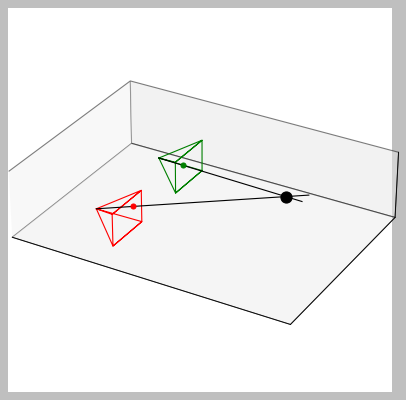

In [1784]:
plotSolution(t_target, t_cam, R_cam, z_sol) # filename='img/disparity.png'

In [1785]:
# number of cameras
n_cam = 3
# translation of the cameras
t_cam = np.zeros((3,n_cam))
t_cam[:,0] = np.array([0,0,0])
t_cam[:,1] = np.array([0.2,1,-0.2])
t_cam[:,2] = np.array([-0.3,-1,0.1])
# rotation of the cameras
R_cam = np.zeros((3,3,n_cam))
R_cam[:,:,0] = R.Rotation.from_euler('xyz', [0.0, 1.2, 0.0]).as_matrix()
R_cam[:,:,1] = R.Rotation.from_euler('xyz', [0.1, 1.2, -0.3]).as_matrix()
R_cam[:,:,2] = R.Rotation.from_euler('xyz', [-0.1, 1.2, 0.3]).as_matrix()
# intrinsic camera parameters (focal length and principal point) assume same for all cameras
F_cam = np.zeros((3,3,n_cam))
F_cam[:,:,0] = np.array([[300, 0, 1080/2],[0, 300, 720/2],[0, 0, 1]])
F_cam[:,:,1] = F_cam[:,:,0].copy()
F_cam[:,:,2] = F_cam[:,:,0].copy()

Error for target: [-1.11022302e-15 -2.22044605e-16  2.77555756e-16]
Error for depth: [-1.99840144e-15 -4.44089210e-16 -8.88178420e-16]


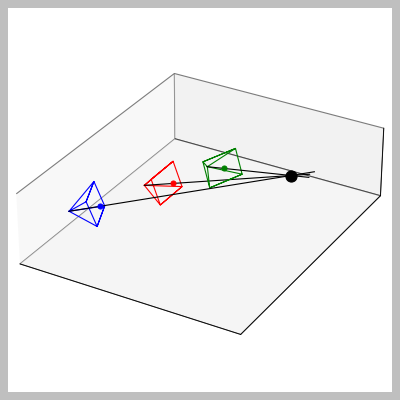

In [1786]:
p_target, z_target = genPixelCoordinates(n_cam, F_cam, R_cam, t_cam, t_target)
A_cam, b_cam = buildLinearSystem(n_cam, F_cam, R_cam, t_cam, p_target)
z_sol, t_sol = solveLinearSystem(n_cam, A_cam, b_cam)

print(f'Error for target: {t_sol - t_target}')
print(f'Error for depth: {z_sol - z_target}')

plotSolution(t_target, t_cam, R_cam, z_sol) # filename='img/simple.png'

Error for target: [0.0477288  0.03964309 0.01746113]
Error for depth: [0.02804277 0.03166521 0.08630202]


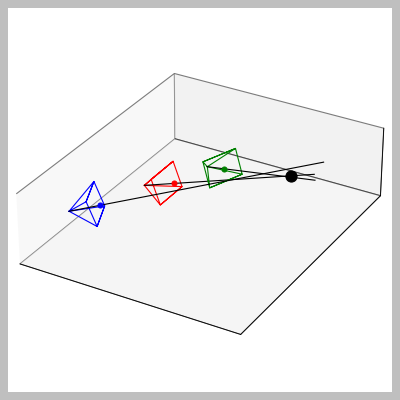

In [1787]:
p_target, z_target = genPixelCoordinates(n_cam, F_cam, R_cam, t_cam, t_target, noise=20)
A_cam, b_cam = buildLinearSystem(n_cam, F_cam, R_cam, t_cam, p_target)
z_sol, t_sol = solveLinearSystem(n_cam, A_cam, b_cam)

print(f'Error for target: {t_sol - t_target}')
print(f'Error for depth: {z_sol - z_target}')

plotSolution(t_target, t_cam, R_cam, z_sol) # filename='img/noise.png'

In [1788]:
# number of cameras
n_cam = 8
# translation of the cameras
t_cam = np.array([[0.2, 1.0, 0.2]]).T * (np.random.random((3,n_cam)) - 0.5) * 2.0
# rotation of the cameras
R_cam = np.zeros((3,3,n_cam))
for i in range(n_cam):
    angles = 0.1 * (np.random.random(3) - 0.5) * 2.0
    angles[1] += 1.2
    R_cam[:,:,i] = R.Rotation.from_euler('xyz', angles).as_matrix()
# intrinsic camera parameters (focal length and principal point) assume same for all cameras
F = np.array([[300, 0, 1080/2],[0, 300, 720/2],[0, 0, 1]])
F_cam = np.repeat(F[:, :, np.newaxis], n_cam, axis=2)

Error for target: [0.02666264 0.01967932 0.02572464]
Error for depth: [-0.00549693  0.0155717   0.04151249  0.04561202  0.02856217  0.04985955
  0.05768887  0.04316114]


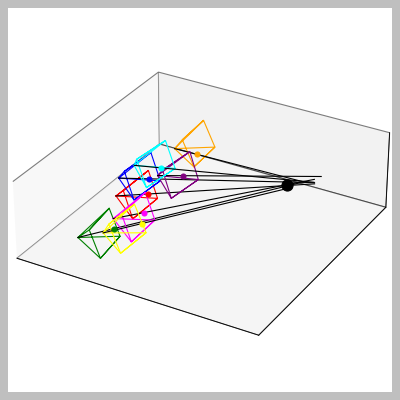

In [ ]:
p_target, z_target = genPixelCoordinates(n_cam, F_cam, R_cam, t_cam, t_target, noise=20)
A_cam, b_cam = buildLinearSystem(n_cam, F_cam, R_cam, t_cam, p_target)
z_sol, t_sol = solveLinearSystem(n_cam, A_cam, b_cam)

print(f'Error for target: {t_sol - t_target}')
print(f'Error for depth: {z_sol - z_target}')

plotSolution(t_target, t_cam, R_cam, z_sol) # filename='img/madness.png'